# Geostrophic velocities calculated from sea level contours

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np 

import xgcm
from gsw import f, grav, p_from_z

import matplotlib.pyplot as plt
import cmocean as cm

import warnings
warnings.filterwarnings("ignore")

## Load ACCESS OM-2 interannual forcing simulation

In [2]:
session = cc.database.create_session()

expt = '01deg_jra55v140_iaf'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40507,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:45199,Total threads: 4
Dashboard: /proxy/34385/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43857,


In [4]:
# time limits of dataset
start_time, end_time = '1997-04-01', '1997-04-30'

# data output frequency
freq = '1 daily'

Load model variables and coordinates.

In [5]:
# load sea level and total simulated velocities
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start_time, end_time=end_time)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start_time, end_time=end_time)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start_time, end_time=end_time)

# load coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

## Select region of interest

We select a small subset of the global data, over a Subantarctic Front meander in the Antarctic Circumpolar Current.

In [6]:
# location limits of dataset
lon_lim = slice(-224.2, -212)
lat_lim = slice(-53.5, -47.5)

# time periods
flex_period = slice('1997-04-10', '1997-04-25')

In [7]:
sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

# coordinates
lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

## Define staggered grid (Arakawa B) with help of `xgcm` package
The way `xgcm` works is that we first create a `grid` object that has all the information regarding our staggered grid. For our case, `grid` needs to know the location of the `xt_ocean`, `xu_ocean` points (and same for y) and their relative orientation to one another, i.e., that `xu_ocean` is shifted to the right of `xt_ocean` by $\frac{1}{2}$ grid-cell.

In [8]:
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
vel = xr.merge([coordinates, sl_lim.sel(time=flex_period),
                u_lim.sel(time=flex_period), v_lim.sel(time=flex_period)])

vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(vel, periodic=False, boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

## Calculate geostrophic velocities

The geostrophic velocities at the surface can be calculated from sea level contours. This can be done from satellite altimetry by using the SSH contours or in the ACCESS-OM2 simulation by using the sea level contours. The relation between the surface geostrophic zonal ($u_{g,s}$) and meridional ($v_{g,s}$) velocities and the sea level ($\eta$) are as follow:

\begin{eqnarray}
    u_{g,s} = -\frac{g}{f}\frac{\partial \eta}{\partial y} \\
    v_{g,s} = \frac{g}{f}\frac{\partial \eta}{\partial x}
\end{eqnarray}

where $g$ is the gravitational acceleration and $f$ is the Coriolis parameter.

Below you see these equations in a function, which uses the Grid that we made with the use of `xgcm` above and the variables stored in the `xarray` Dataset.

In [9]:
def geostrophic_velocity(ds, grid, sea_level='sea_level', stream_func='deltaD', gravity='gu', coriolis='f', delta_names=('dx', 'dy')):

    '''
    calculate geostrophic velocity from sea level
    '''
    
    # surface geostrophic velocity
    detadx = grid.interp(grid.diff(ds[sea_level], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]]
    detady = grid.interp(grid.diff(ds[sea_level], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    ds['ug_s']= - (ds[gravity] / ds[coriolis]) * detady
    ds['vg_s'] = (ds[gravity] / ds[coriolis]) * detadx

    ds['ug_s'].name = 'ug_s'
    ds['ug_s'].attrs['standard_name'] = 'surface_geostrophic_eastward_sea_water_velocity'
    ds['ug_s'].attrs['long_name'] = r'$u_g,s$'
    ds['ug_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['vg_s'].name = 'vg_s'
    ds['vg_s'].attrs['standard_name'] = 'surface_geostrophic_northward_sea_water_velocity'
    ds['vg_s'].attrs['long_name'] = r'$v_g,s$'
    ds['vg_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    return ds

In order to make an accurate calculation of the gravitational acceleration and the Coriolis parameter, we have to prepare the data such that the `gsw` functions receive the data in the correct way. We expand the latitude and vertical coordinates into 2-dimensional arrays and transform the vertical coordinate into a pressure coordinate. 

In [10]:
lat_t_2d = lat_t.broadcast_like(coordinates.dyt)
z_2d = (-vel.isel(st_ocean=0).st_ocean).broadcast_like(coordinates.dyt)
p_2d = xr.apply_ufunc(p_from_z, z_2d, lat_t_2d, dask='parallelized', output_dtypes=[z_2d.dtype])
p_2d = p_2d.compute()

In [11]:
g = xr.apply_ufunc(grav, lat_t, p_2d, dask='parallelized', output_dtypes=[p_2d.dtype])
g.name = 'g'
g.attrs = {'standard_name': 'gravitational_acceleration', 'units':r'$\textrm{ms}^{-2}$', 'long_name': 'gravitational acceleration'}

# Coriolis parameter
fcor, _ = xr.broadcast(f(coordinates.yu_ocean), coordinates.xu_ocean)
fcor.name = 'f'
fcor.attrs = {'standard_name': 'coriolis_parameter', 'units': r'$\textrm{s}^{-1}$', 'long_name': 'Coriolis parameter'}

gu = grid.interp(grid.interp(g, 'X', boundary='extend'), 'Y', boundary='extend')
gu.name = 'gu'

Adding the gravitational acceleration and the Coriolis parameter to the `xarray` Dataset, makes it easy for the function to read all the variables at once. We have selected a time period of 16 day, in which a standing meander in the Antarctic Circumpolar Current is flexed (or maturely developed).

In [12]:
sl_grd = xr.merge([coordinates, g, gu, fcor, sl_lim.sel(time=flex_period)])
sl_grd

<xarray.Dataset>
Dimensions:    (xt_ocean: 122, yt_ocean: 95, xu_ocean: 122, yu_ocean: 94,
                time: 16)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
    st_ocean   float64 0.5413
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    g          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(95, 122), meta=np.ndarray>
    gu         (yu_ocean, xu_ocean) float64 dask.array<chunksize=(94, 122), meta=np.ndarray>
    f          (yu_ocean, xu_ocean) float64 -0.0001172 -0.0001172 ... -0.0001076
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 95, 122), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

Now, we just have to provide the function `geostrophic_velocity` with the variables in the Dataset, the Grid made with `xgcm`, we set stream_func to None, because we only calculate the geostrophic velocities at the surface and we provide the names of $dx$ and $dy$ in the Dataset.

In [13]:
geos_vel = geostrophic_velocity(sl_grd, grid, stream_func=None, delta_names=('dxu', 'dyu'))

# calculating the geostrophic flow speed
Vg = (geos_vel.ug_s**2 + geos_vel.vg_s**2)**(1/2)

We have now calculated the geostrophic velocities and we can make a plot, in which we show the geostrophic flow speed averaged over the 16-day period with the sea level contours overlaid.

Text(0.5, 1.0, 'Surface geostrophic velocities computed using SSH')

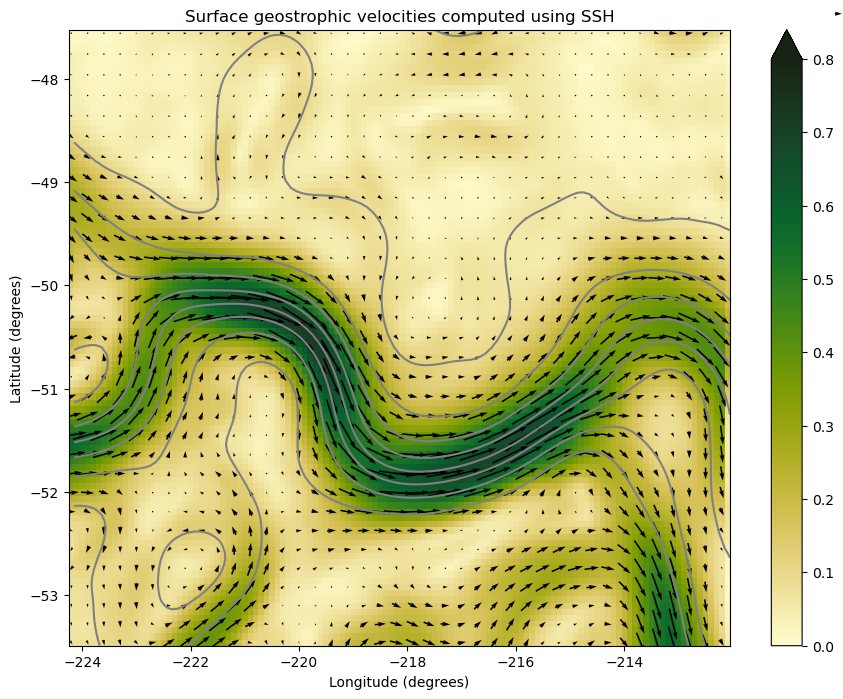

In [14]:
# to select every third cell
slc = xt_ocean=slice(None, None, 3)

Vg.mean('time').plot(size=8, cmap=cm.cm.speed, vmin=0, vmax=0.8, extend='max')
geos_vel.mean('time').sea_level.plot.contour(levels=np.linspace(-0.7, 0, 8), colors='gray', linestyles='solid')
geos_vel.mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(x='xu_ocean', y='yu_ocean', u='ug_s', v='vg_s')

plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Surface geostrophic velocities computed using SSH')

We can compare the geostrophic velocities to the total simulated velocities at the surface and see what the difference in flow speed is. The difference is made up of the various contributions to the ageostrophic flow, such as the Ekman velocities and velocities driven by advection (curvature in the flow field).

In [15]:
# calculating the total flow speed from the simulated velocities at the surface
V_s = (vel.u.isel(st_ocean=0)**2 + vel.v.isel(st_ocean=0)**2)**(1/2)

vel['uag'] = vel.u.isel(st_ocean=0) - geos_vel.ug_s
vel['vag'] = vel.v.isel(st_ocean=0) - geos_vel.vg_s

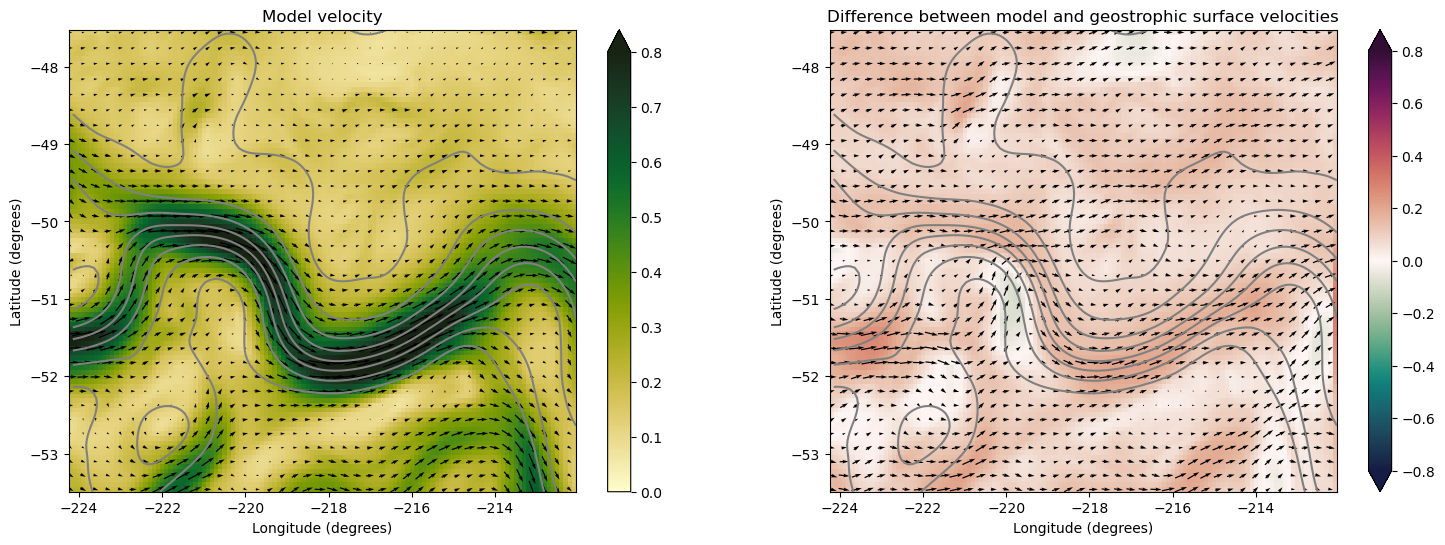

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot total flow speed
V_s.mean('time').plot(ax=axes[0], cmap=cm.cm.speed, vmin=0, vmax=0.8)

vel.mean('time').isel(st_ocean=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(ax=axes[0],
                                                                              x='xu_ocean', y='yu_ocean',
                                                                              u='u', v='v',
                                                                              add_guide = False)

# Plot ageostrophic flow speed
(V_s - Vg).mean('time').plot(ax=axes[1], cmap=cm.cm.curl, vmin=-0.8, vmax=0.8, extend='both')

vel.mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(ax=axes[1],
                                                             x='xu_ocean', y='yu_ocean',
                                                             u='uag', v='vag',
                                                             add_guide = False)

for ax in axes:
    vel.sea_level.mean('time').plot.contour(ax=ax,
                                            levels=np.linspace(-0.7, 0, 8),
                                            colors='gray',
                                            linestyles='solid')
    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')

axes[0].set_title('Model velocity')
axes[1].set_title('Difference between model and geostrophic surface velocities');

It is interesting that the total flow speed is almost everywhere larger than the geostrophic flow speed due to the prevailing westerlies. However, where the streamlines are strongly curved agesotrophic velocities due to the advection (curvature) terms become important.